# 1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 2. Load the Dataset

In [3]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')


# 3. Merge Datasets
We combine the datasets to create a unified DataFrame:

In [4]:
df = pd.merge(train, stores, on='Store')
df = pd.merge(df, features, on=['Store', 'Date', 'IsHoliday'])


# 4. Convert Date Column to Datetime Format
We ensure the Date column is in datetime format:

In [5]:
df['Date'] = pd.to_datetime(df['Date'])


# 5. Exploratory Data Analysis (EDA)

**a. Overview of the Data**

In [6]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

**b. Visualize Sales Trends**

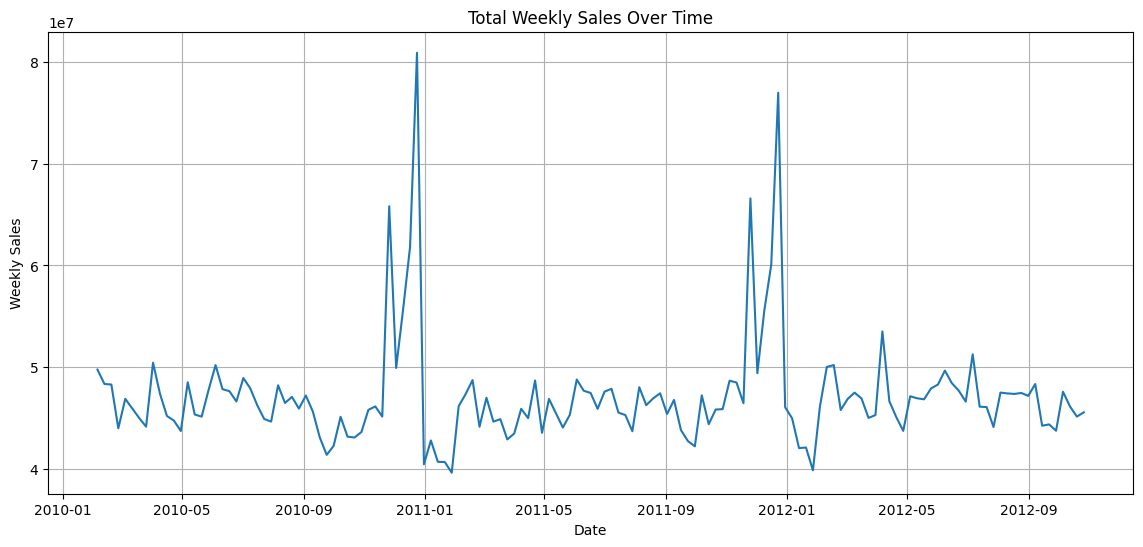

In [7]:
# We aggregate sales data by date and plot:

sales_trend = df.groupby('Date')['Weekly_Sales'].sum()
plt.figure(figsize=(14, 6))
plt.plot(sales_trend)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()


# 6. Data Preprocessing

**a. Handle Missing Values**

In [8]:
print(df.isnull().sum())
df.fillna(method='ffill', inplace=True)


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64


<ipython-input-8-76e85a1d42e6>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


**b. Feature Engineering**

In [9]:
# We create additional time-based features:

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week


# 7. Aggregate Sales Data for Forecasting

For simplicity, focus on total weekly sales across all stores:

In [10]:
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
weekly_sales.set_index('Date', inplace=True)


# 8. Time Series Decomposition

**We decompose the time series to observe trend, seasonality, and residuals:**

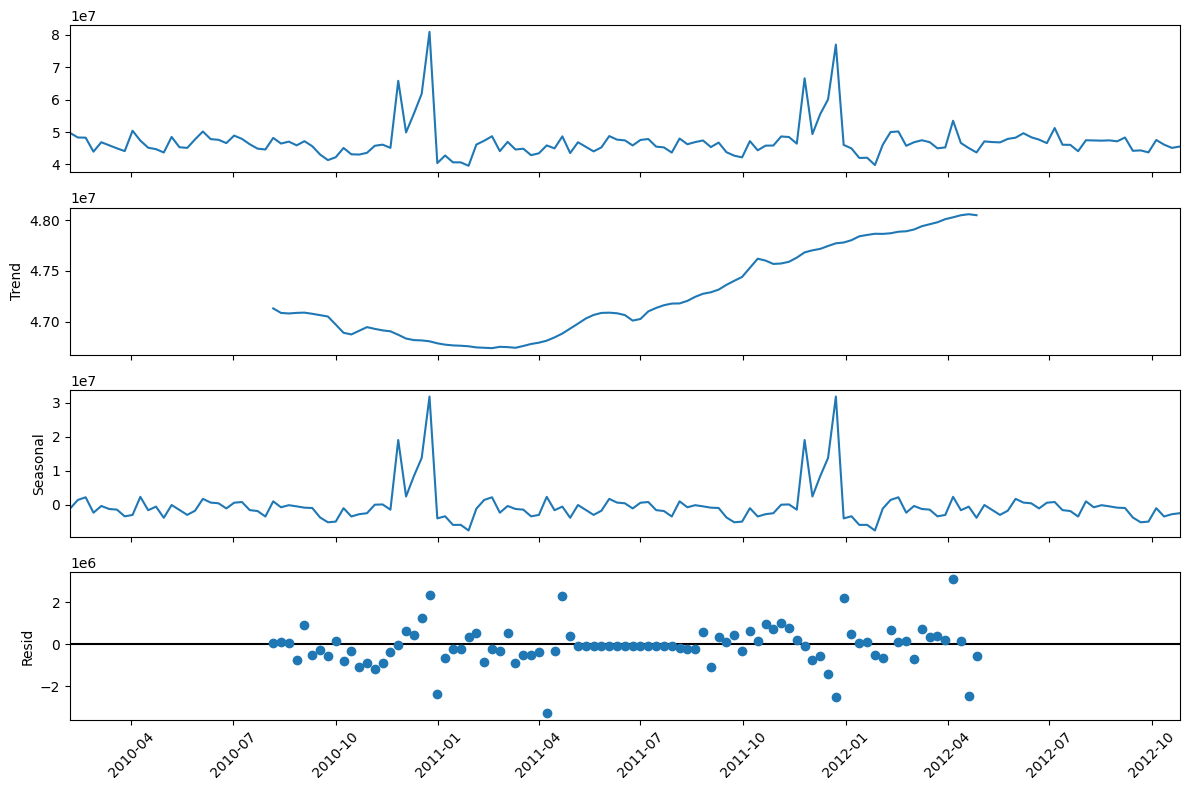

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
decomposition = seasonal_decompose(weekly_sales, model='additive')

# Plot with better readability
fig = decomposition.plot()
fig.set_size_inches(12, 8)  # Increase figure size

# Rotate x-axis labels for all subplots
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 9. Check for Stationarity

**We use the Augmented Dickey-Fuller test to assess stationarity:**

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(weekly_sales['Weekly_Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -5.908297957186333
p-value: 2.675979158986027e-07


# 10. Differencing to Achieve Stationarity

In [14]:
weekly_sales_diff = weekly_sales.diff().dropna()


# 11. Plot ACF and PACF

**We visualize the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF):**

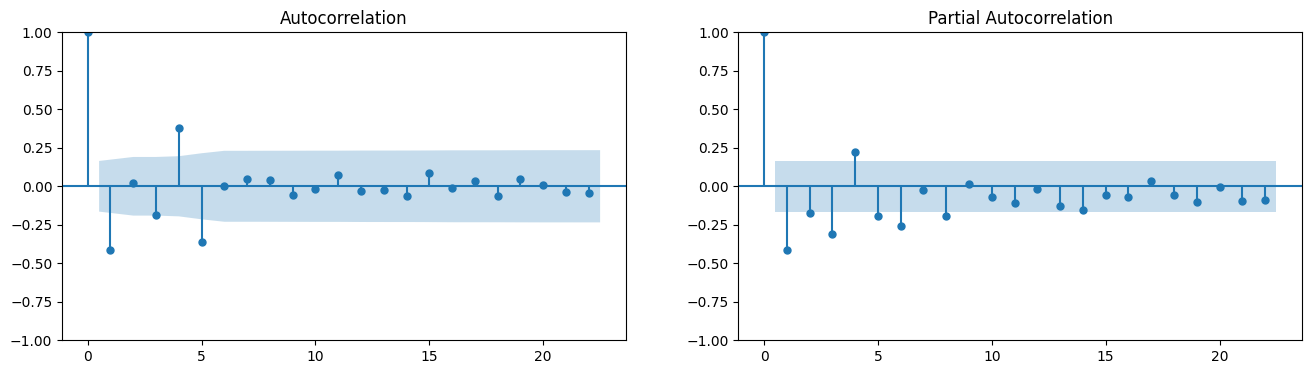

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(weekly_sales_diff, ax=ax[0])
plot_pacf(weekly_sales_diff, ax=ax[1])
plt.show()


# 12. Fit ARIMA Model

In [16]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(weekly_sales, order=(1, 1, 1))
arima_result = model.fit()
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2407.205
Date:                Fri, 28 Mar 2025   AIC                           4820.410
Time:                        18:08:34   BIC                           4829.277
Sample:                    02-05-2010   HQIC                          4824.013
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4556      0.065      6.965      0.000       0.327       0.584
ma.L1         -0.9767      0.038    -25.432      0.000      -1.052      -0.901
sigma2      3.067e+13   7.95e-16   3.86e+28      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


# 13. Forecast with ARIMA

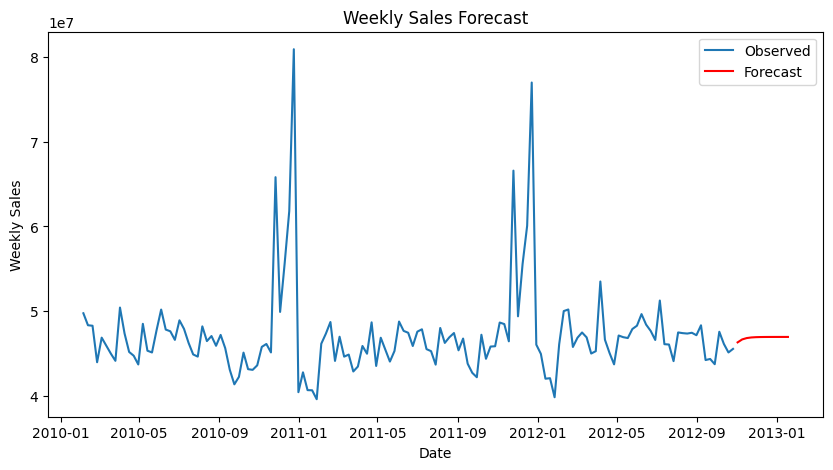

In [17]:
forecast = arima_result.forecast(steps=12)
plt.figure(figsize=(10, 5))
plt.plot(weekly_sales, label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Weekly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()


# 14. Fit Prophet Model

In [18]:
!pip install prophet
from prophet import Prophet


In [19]:
prophet_df = weekly_sales.reset_index().rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})


In [20]:
prophet_model = Prophet()
prophet_model.fit(prophet_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqqs9yqrk/7cwmw49w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqqs9yqrk/z82lq6tg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76543', 'data', 'file=/tmp/tmpqqs9yqrk/7cwmw49w.json', 'init=/tmp/tmpqqs9yqrk/z82lq6tg.json', 'output', 'file=/tmp/tmpqqs9yqrk/prophet_modelx0vk1ylk/prophet_model-20250328180930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:09:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:09:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# 15. Forecast with Prophet

We create a dataframe for future dates and generate forecasts:

In [21]:
future = prophet_model.make_future_dataframe(periods=12, freq='W')
forecast = prophet_model.predict(future)


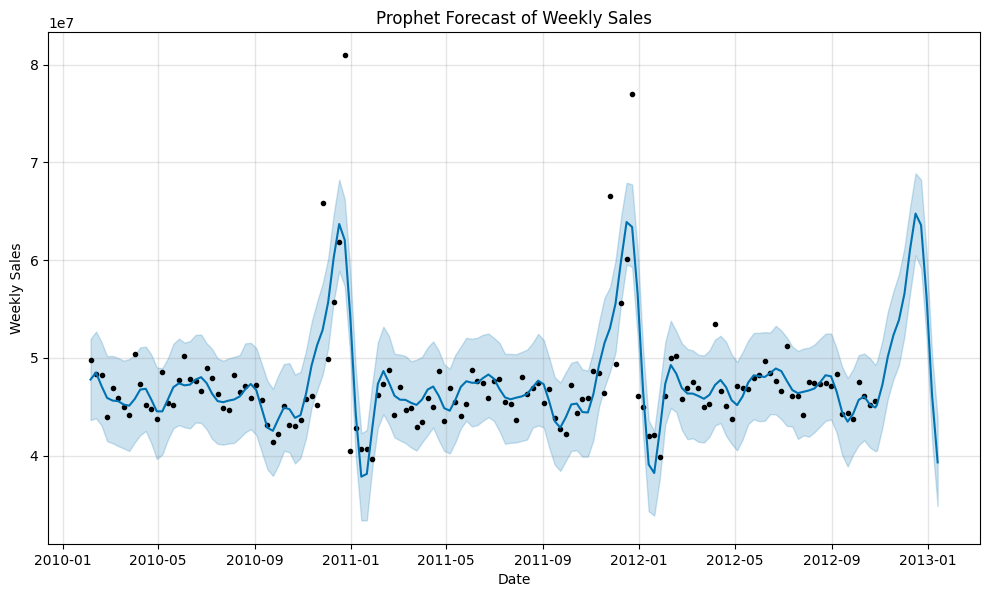

In [22]:
prophet_model.plot(forecast)
plt.title('Prophet Forecast of Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()


# 16. Evaluate Model Performance

**We compare the forecasts with actual sales using metrics like Mean Absolute Error (MAE):**

In [24]:
from sklearn.metrics import mean_absolute_error

# Get actual sales (last 12 weeks of known data)
actual = weekly_sales['Weekly_Sales'][-12:].values

# Forecasted ARIMA values (make sure it's a NumPy array or Series)
predicted_arima = arima_result.forecast(steps=12).values

# MAE calculation
mae_arima = mean_absolute_error(actual, predicted_arima)
print(f'ARIMA MAE: {mae_arima:.2f}')


ARIMA MAE: 1440699.23


**For Prophet Forecast:**

In [25]:
# Prophet predicted values
predicted_prophet = forecast['yhat'][-12:].values

# Prophet MAE
mae_prophet = mean_absolute_error(actual, predicted_prophet)
print(f'Prophet MAE: {mae_prophet:.2f}')


Prophet MAE: 8255984.62
